In [43]:
import openai
import json

from execenvtool import ExecutionEnvironment

%reload_ext autoreload
%autoreload 2

In [44]:
from dotenv import load_dotenv

load_dotenv()

False

In [45]:
tools = [ {
    'type': 'function',
    'function': {
        "name": "pyExec",
        "description": "Ejecuta código Python en un entorno persistente.",
        "parameters": {
            "type": "object",
            "properties": {
                "code": {"type": "string", "description": "El código Python a ejecutar."}
            },
            "required": ["code"]
            }
        }
    },
    {
    'type': 'function',
    'function': {
        "name": "format_variable",
        "description": "Formatea una variable del entorno para hacerla entendible por el LLM.",
        "parameters": {
            "type": "object",
            "properties": {
                "var_name": {"type": "string", "description": "Nombre de la variable a formatear."}
            },
            "required": ["var_name"]
            }
        }
    }
    ]

In [46]:
# Instanciar el entorno
env = ExecutionEnvironment()

client =openai.OpenAI()

messages = []

def process_response(response):
    response_message = response.choices[0].message
    messages.append(response_message)
    
    if dict(response_message).get('tool_calls'):
        
        for tool_call in response_message.tool_calls:
            # Which function call was invoked
            function_called = tool_call.function.name
            
            # Extracting the arguments
            function_args  = json.loads(tool_call.function.arguments)
        
            # Function names
            available_functions = {
                "pyExec": env.pyExec,
                "format_variable": env.format_variable
            }
            
            fuction_to_call = available_functions[function_called]
            response_message = json.dumps(fuction_to_call(*list(function_args .values())))
            
            messages.append({"tool_call_id": tool_call.id,
                            "role": "tool",
                            "name": function_called,
                            "content": response_message,
                            })
            
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            tools=tools,
            tool_choice="auto"
            )
        
        process_response(response)
        
    else:
        response_message = response_message.content
        messages.append({"role": "assistant",
                         "content": response_message,
                         })
        
    return response

In [47]:
# Mensaje del usuario
messages = [
    {
        "role": "system", 
        "content": 
            """
            Eres un programador experto en Python. 
            Respetas siempre PEP8. 
            Tu objetivo es escribir el código necesario para realizar la tarea que te pidan. 
            Tus respuestas deben ir en formato markedown.
            """},
    {"role": "user", "content": "Crea una lista de los primeros 100 números y calcula su suma. "},
]

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

In [48]:
process_response(response)

ChatCompletion(id='chatcmpl-AgVHSGemwmdMbwqBFXhi7sEdAN7SO', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_CrPlF7mmw0bWotWoJ1NJNH5R', function=Function(arguments='{"var_name":"numbers"}', name='format_variable'), type='function')]))], created=1734693382, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=16, prompt_tokens=241, total_tokens=257, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [49]:
print(messages[-1]['content'])

He creado una lista con los primeros 100 números, y su suma es:

- **Lista de números**: [1, 2, 3, 4, 5, 6, 7, 8, ..., 99, 100]
- **Suma total**: 5050


In [50]:
# Generate markdown to print messages[-1]['content']
import markdown
from IPython.display import display, Markdown

display(Markdown(markdown.markdown(messages[-1]['content'])))

<p>He creado una lista con los primeros 100 números, y su suma es:</p>
<ul>
<li><strong>Lista de números</strong>: [1, 2, 3, 4, 5, 6, 7, 8, ..., 99, 100]</li>
<li><strong>Suma total</strong>: 5050</li>
</ul>

In [51]:
# Mensaje del usuario
messages.append({"role": "user", "content": "Muestra la variable `numeros` formateada."})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

process_response(response)

ChatCompletion(id='chatcmpl-AgVHWUgBTpkKVpA4SzaHJmisEq4n3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='La variable `numeros` es una lista que contiene los primeros 100 números enteros:\n\n```python\n[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]\n```\n\nSi deseas ver algún otro detalle, házmelo saber.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734693386, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=338, prompt_tokens=774, total_tokens=11

In [52]:
print(messages[-1]['content'])

La variable `numeros` es una lista que contiene los primeros 100 números enteros:

```python
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
```

Si deseas ver algún otro detalle, házmelo saber.


In [53]:
# Mensaje del usuario
messages.append({"role": "user", "content": "Genera un dataframe 10x5 con numeros aleatorios. Asígnalo a la variable `df_random`."})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

process_response(response)

ChatCompletion(id='chatcmpl-AgVHeEf48go2WAafdqIfF60AViIFo', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='He generado un DataFrame de 10 filas por 5 columnas con números aleatorios y lo he asignado a la variable `df_random`. Si deseas ver su contenido, solo dímelo.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734693394, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=42, prompt_tokens=1546, total_tokens=1588, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=1408)))

In [54]:
print(messages[-1]['content'])

He generado un DataFrame de 10 filas por 5 columnas con números aleatorios y lo he asignado a la variable `df_random`. Si deseas ver su contenido, solo dímelo.


In [55]:
# Mensaje del usuario
messages.append({"role": "user", "content": "Muestra el datafrasme `df_random` formateado"})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

process_response(response)

ChatCompletion(id='chatcmpl-AgVHhIzYFsqJ6fh0FegsDR2taI5oG', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Aquí está el DataFrame `df_random` con números aleatorios:\n\n```plaintext\n          0         1         2         3         4\n0  0.570197  0.438602  0.988374  0.102045  0.208877\n1  0.161310  0.653108  0.253292  0.466311  0.244426\n2  0.158970  0.110375  0.656330  0.138183  0.196582\n3  0.368725  0.820993  0.097101  0.837945  0.096098\n4  0.976459  0.468651  0.976761  0.604846  0.739264\n5  0.039188  0.282807  0.120197  0.296140  0.118728\n6  0.317983  0.414263  0.064147  0.692472  0.566601\n7  0.265389  0.523248  0.093941  0.575946  0.929296\n8  0.318569  0.667410  0.131798  0.716327  0.289406\n9  0.183191  0.586513  0.020108  0.828940  0.004695\n```\n\nEste DataFrame tiene 10 filas y 5 columnas, cada una con valores aleatorios entre 0 y 1.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))]

In [56]:
print(messages[-1]['content'])

Aquí está el DataFrame `df_random` con números aleatorios:

```plaintext
          0         1         2         3         4
0  0.570197  0.438602  0.988374  0.102045  0.208877
1  0.161310  0.653108  0.253292  0.466311  0.244426
2  0.158970  0.110375  0.656330  0.138183  0.196582
3  0.368725  0.820993  0.097101  0.837945  0.096098
4  0.976459  0.468651  0.976761  0.604846  0.739264
5  0.039188  0.282807  0.120197  0.296140  0.118728
6  0.317983  0.414263  0.064147  0.692472  0.566601
7  0.265389  0.523248  0.093941  0.575946  0.929296
8  0.318569  0.667410  0.131798  0.716327  0.289406
9  0.183191  0.586513  0.020108  0.828940  0.004695
```

Este DataFrame tiene 10 filas y 5 columnas, cada una con valores aleatorios entre 0 y 1.


In [57]:
# Mensaje del usuario
messages.append({"role": "user", "content": "Calcula estadisticos básicos para todas las columnas `df_random` y assignalas a otro dataframe `df_stats`."})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

process_response(response)

ChatCompletion(id='chatcmpl-AgVHsOBEiQQMnWNsqVe4q9j745uaJ', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_1X5Zvl2YEyixFbEx8LS3u1Ta', function=Function(arguments='{"var_name":"df_stats"}', name='format_variable'), type='function')]))], created=1734693408, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=16, prompt_tokens=3191, total_tokens=3207, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=3072)))

In [58]:
print(messages[-1]['content'])

Aquí están los estadísticos básicos calculados para todas las columnas del DataFrame `df_random`, asignados al nuevo DataFrame `df_stats`:

```plaintext
             0          1          2          3          4
count  10.000000  10.000000  10.000000  10.000000  10.000000
mean    0.336000   0.496597   0.340205   0.525916   0.339397
std     0.267712   0.203715   0.383416   0.268384   0.303381
min     0.039188   0.110375   0.020108   0.102045   0.004695
25%     0.166780   0.420348   0.094731   0.338683   0.138191
50%     0.291686   0.495950   0.125997   0.590396   0.226651
75%     0.356186   0.636459   0.555570   0.710363   0.497303
max     0.976459   0.820993   0.988374   0.837945   0.929296
```

Si necesitas más información, no dudes en preguntar.


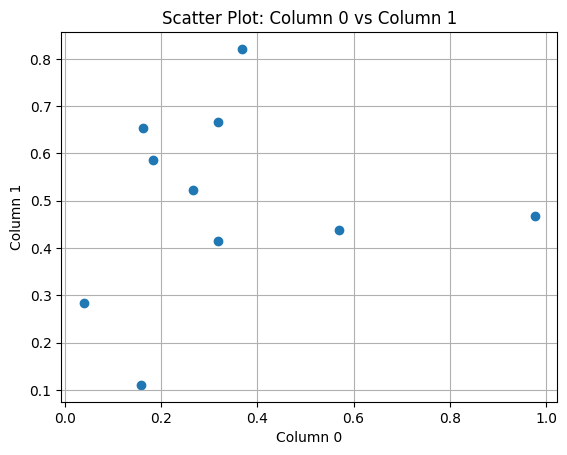

ChatCompletion(id='chatcmpl-AgVI3XdeuEpyF8GbJ9g2AbUiT6HZp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='He generado un gráfico de dispersión (scatter plot) usando las columnas 0 y 1 del DataFrame `df_random`. El gráfico muestra los valores de la columna 0 en el eje x y los valores de la columna 1 en el eje y, lo que permite visualizar cualquier posible relación entre estos dos conjuntos de datos.\n\nSi necesitas otra visualización o ayuda adicional, házmelo saber.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734693419, model='gpt-4o-2024-08-06', object='chat.completion', service_tier=None, system_fingerprint='fp_5f20662549', usage=CompletionUsage(completion_tokens=83, prompt_tokens=4509, total_tokens=4592, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTo

In [59]:
messages.append({"role": "user", "content": "Crea un scatter plot con las columnas 0 y 1 de `df_random`."})

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
)

process_response(response)

In [60]:
print(messages[-1]['content'])

He generado un gráfico de dispersión (scatter plot) usando las columnas 0 y 1 del DataFrame `df_random`. El gráfico muestra los valores de la columna 0 en el eje x y los valores de la columna 1 en el eje y, lo que permite visualizar cualquier posible relación entre estos dos conjuntos de datos.

Si necesitas otra visualización o ayuda adicional, házmelo saber.


In [61]:
messages

[{'role': 'system',
  'content': '\n            Eres un programador experto en Python. \n            Respetas siempre PEP8. \n            Tu objetivo es escribir el código necesario para realizar la tarea que te pidan. \n            Tus respuestas deben ir en formato markedown.\n            '},
 {'role': 'user',
  'content': 'Crea una lista de los primeros 100 números y calcula su suma. '},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_DIpYqRcM1BFLMEGLxOEoN5vs', function=Function(arguments='{"code": "numbers = list(range(1, 101))"}', name='pyExec'), type='function'), ChatCompletionMessageToolCall(id='call_AieYO82P7p4tOr6lMzqNcZOj', function=Function(arguments='{"code": "total_sum = sum(numbers)"}', name='pyExec'), type='function')]),
 {'tool_call_id': 'call_DIpYqRcM1BFLMEGLxOEoN5vs',
  'role': 'tool',
  'name': 'pyExec',
  'content': '["numbers"]'},
 {'tool_call_id': 'call_AieYO82P

In [62]:
env.get_environment().keys()

dict_keys(['numbers', 'total_sum', 'pd', 'np', 'df_random', 'df_stats', 'plt'])

In [64]:
env.get_environment()['plt'].__dir__()

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__file__',
 '__cached__',
 '__builtins__',
 '__annotations__',
 'annotations',
 'AbstractContextManager',
 'ExitStack',
 'Enum',
 'functools',
 'importlib',
 'inspect',
 'logging',
 'sys',
 'threading',
 'time',
 'TYPE_CHECKING',
 'cast',
 'overload',
 'cycler',
 'matplotlib',
 '_api',
 'get_backend',
 'rcParams',
 'cm',
 'style',
 '_pylab_helpers',
 'interactive',
 'cbook',
 '_docstring',
 'FigureCanvasBase',
 'FigureManagerBase',
 'MouseButton',
 'Figure',
 'FigureBase',
 'figaspect',
 'GridSpec',
 'SubplotSpec',
 'rcsetup',
 'rcParamsDefault',
 'rcParamsOrig',
 'Artist',
 'Axes',
 'Subplot',
 'BackendFilter',
 'backend_registry',
 'PolarAxes',
 '_ColorizerInterface',
 'ColorizingArtist',
 'Colorizer',
 'mlab',
 'get_scale_names',
 '_colormaps',
 '_color_sequences',
 'Colormap',
 'np',
 'Normalize',
 'Line2D',
 'AxLine',
 'Text',
 'Annotation',
 'Arrow',
 'Circle',
 'Rectangle',
 'Polygon',
 'Button',
 'Slider',
 